# Create a Concept Network
Here we
1. Load and filter the publication-concept files
2. Use the files to create the edge and node sets
3. Build a network
4. Do some basic visualizations of subsets of the network

The first parts (1-3) should probably eventually be turned into a function in some type of `utils.py` file since it seems like something we'll be working with a lot this project, oatpy can (at least at first glance) take networkx graphs as inputs for the homology functions so it's particularly useful, and networkx graphs can be turned into Julia graph packages (which I assume can be converted into a workable format for Ripserer, I haven't looked into it).

#### Preliminaries

In [1]:
# load some packages
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

# configuration
DATA_PATH = 'datasets/concept_network/'
CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
NUM_ARTICLE_MIN = 1 # concept must have more than this number of articles about it
NUM_ARTICLE_MAX = np.inf # concept must have less than this number of articles about it
RELEVANCE_CUTOFF = 0.7

#### Load and filter the data
We use a relatively high filter value for relevance to create a manageable network on our laptops.

The article min cutoff is set to make sure there are to typos and such includes and a max cutoff is available, but not set, in case you want to get rid of any ubiquitous concepts (I haven't done anything with this yet tho)

In [2]:
# load the data
article_concept_df = pd.read_csv(DATA_PATH + CONCEPT_FILE)

# filter the data
article_concept_df = article_concept_df[article_concept_df['dfreq_in_category_for_2l'] > NUM_ARTICLE_MIN] # remove rows representing rare concepts
article_concept_df = article_concept_df[article_concept_df['dfreq_in_category_for_2l'] < NUM_ARTICLE_MAX] # remove rows representing ubiquitous concepts
article_concept_df = article_concept_df[article_concept_df['mean'] > RELEVANCE_CUTOFF] # filter relevance
article_concept_df = article_concept_df.rename(columns={ # rename for clarity
        "mean":"relevance_mean",
        "size":"concept_freq_in_abstract"
    })

article_concept_df

,article_id,category_for_2l_code,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
5803,pub.1001518063,102,2009,a a samarskii,0.827,1,0,2,1
5804,pub.1116143236,102,2019,a a samarskii,0.826,1,0,2,1
6612,pub.1129805535,102,2020,a0 mode,0.746,1,0,7,2
6617,pub.1127532815,102,2020,a0 mode,0.746,1,1,7,2
7272,pub.1091364723,102,2017,aal system,0.716,1,0,2,1
...,...,...,...,...,...,...,...,...,...
26396881,pub.1137738984,102,2021,ϵ constraint method,0.751,1,47,11,1
26396959,pub.1137429764,102,2021,ϵ optimal policy,0.721,1,59,4,1
26398822,pub.1031292030,102,2011,’s min – max game theory,0.767,1,48,3,1
26398823,pub.1040935245,102,1994,’s min – max game theory,0.771,1,83,3,2


#### Build graph attributes
We create a set of nodes from all unique concepts in the article-concept pair dataframe

To create the set of edges, we merge the relevant parts of the dataframe on itself and do some basic filtering to remove cases where
- a concept is mapped to itself (Exclude the row)
- there are two edges representing the same concept link (Keep only one)
    - Every concept is mapped both a - b and b - a
- the same concepts are linked multiple times in different articles (Keep the earliest one, exclude the others)
Then, we reformat everything into (source, target, attribute dict) pairs that can be used to create an edge in networkx

In [3]:
## graph attributes
# nodes
nodes = article_concept_df['concept'].unique()

# edges
edge_df = article_concept_df[['article_id', 'year', 'concept']].merge( # combine to make edge list
        right=article_concept_df[['article_id', 'year', 'concept']],
        on=['article_id', 'year'],
        how='outer'
    )
edge_df = edge_df[edge_df['concept_x'] < edge_df['concept_y']] # remove rows where the concepts are equal and make sure theres only one of each row
edge_df = edge_df.sort_values( # sort to get the earlier year to the start
        ['concept_x', 'year'] # technially don't need to sort by concept_x, but it makes it easier for a human to understand
    ).drop_duplicates( # Keep only the first occurance if a row is duplicated
        subset=['concept_x', 'concept_y']
    )

edge_tuple_gen  = lambda row: ( # map to make edge tuples
        row['concept_x'], # edge source
        row['concept_y'], # edge target
        { # dict of attributes
            'article_id': row['article_id'], # article edge is from
            'year': row['year'] # year article was published in
        }
    )
edges = np.array(edge_df.apply(edge_tuple_gen, axis=1)) # make edge tuples

#### Make the graph
Use the edge and node sets earlier to create the graph.

This could also be done using
```
nx.from_pandas_edgelist(
        edge_df, source='concept_x',
        target='concept_y',
        edge_attr=[
                'article_id',
                'year'
            ]
    )
```
but then any disconnected, isolate nodes would be excluded.

In [4]:
## make the graph
concept_G = nx.Graph()
concept_G.add_nodes_from(nodes)
concept_G.add_edges_from(edges)

#### Get some graph info
Get some basic graph info (number of nodes, number of edges, the graph density, the connected components).

We could also look at some centrality stuff fairly easily. Some we'd have to do on only the largest connected component, but that's most (~91%) of the graph.

In [5]:
# number of nodes
len(concept_G.nodes)

162221

In [6]:
# number of edges
len(concept_G.edges)

1694504

In [7]:
# graoph density
nx.density(concept_G)

0.0001287837665251175

In [8]:
# the year and article for an arbitrary edge
edge_tuple = tuple(edge_df.loc[1, :][['concept_x', 'concept_y']]) # tuple for an arbitary edge
concept_G.edges[edge_tuple]

{'article_id': 'pub.1001518063', 'year': 2009}

In [9]:
# The conected components and their sizes
ccs = np.array([c for c in nx.connected_components(concept_G)])
len_ccs = np.array([len(c) for c in ccs])
ccs = ccs[np.argsort(len_ccs)[::-1]]
ccs[1] # 0 is really big

{'cognitive pattern',
 'depressive symptom',
 'emotion regulation',
 'emotional distress',
 'internet',
 'internet addiction',
 'large scale community base study',
 'latent predictor',
 'life event',
 'life event questionnaire',
 'negative emotion',
 'perceive stress',
 'psychological health',
 'psychological problem',
 'self report questionnaire',
 'stressful life event',
 'stressful life event questionnaire'}

#### Visualize a Graph
Most of this code is stolen from Russ (networks crash course notebook)

We only visualize connected component subgraphs that aren't the LCC since the graph (and LCC) is big and so features wouldn't be noticeable and the visualization wouldn't be informative

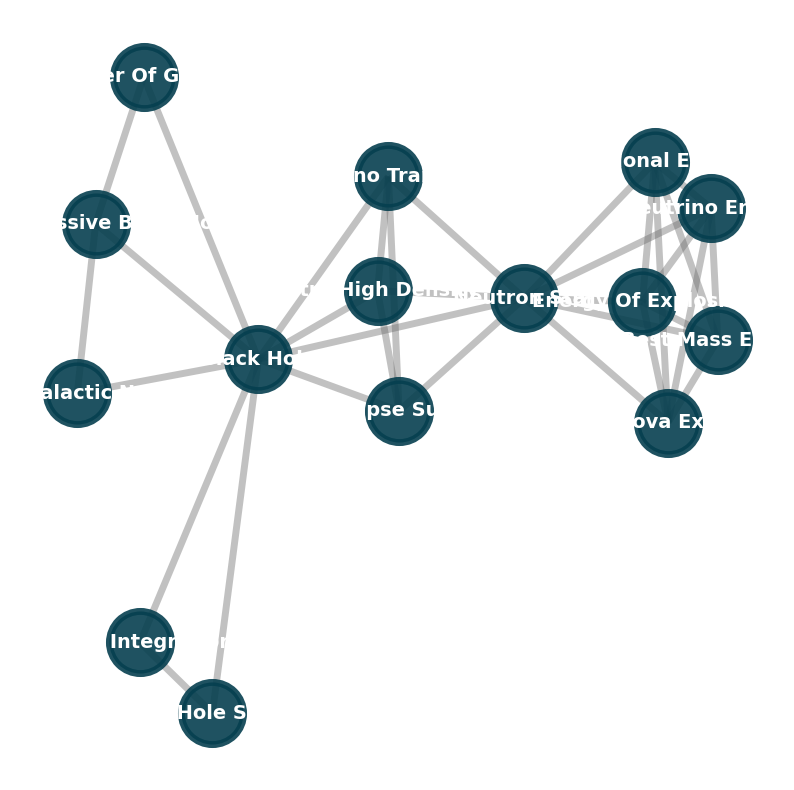

In [10]:
def visualize_graph(G, layout_seed=100):
    pos = nx.spring_layout(G, seed=layout_seed) # setup graph layout
    names_formatted = {n:n.title() for n in G.nodes()} # name lables

    plt.figure(figsize=(10, 10), frameon=False) # create plot
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="#074050", alpha=0.9, linewidths=5).set_edgecolor("#074050") # draw nodes
    nx.draw_networkx_edges(G, pos, alpha=0.4, node_size=0, width=5, edge_color="#666666") # draw edges
    nx.draw_networkx_labels(G, pos, names_formatted, font_size=14, font_color="#ffffff", font_weight="bold") # draw labels

visualize_graph(nx.subgraph(concept_G, ccs[3])) # any subgraph except 0 works. This ones just cool